In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [24]:

df = pd.read_csv('Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [25]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

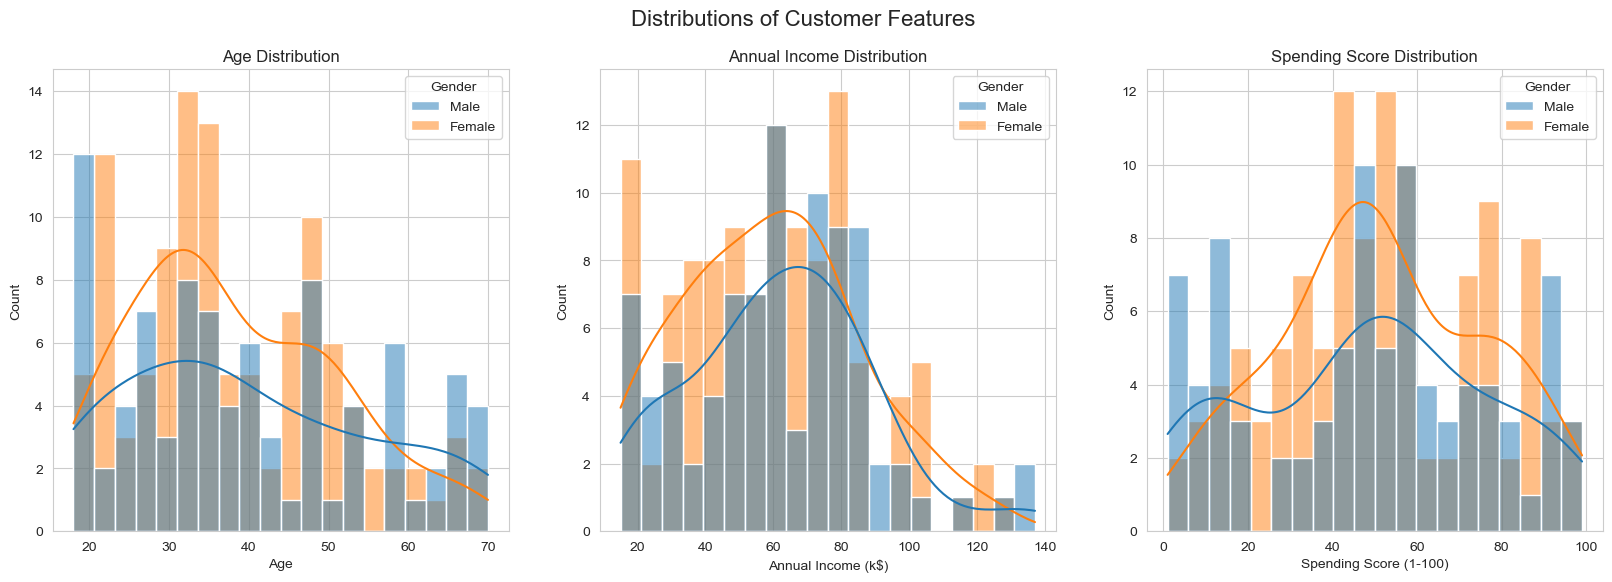

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

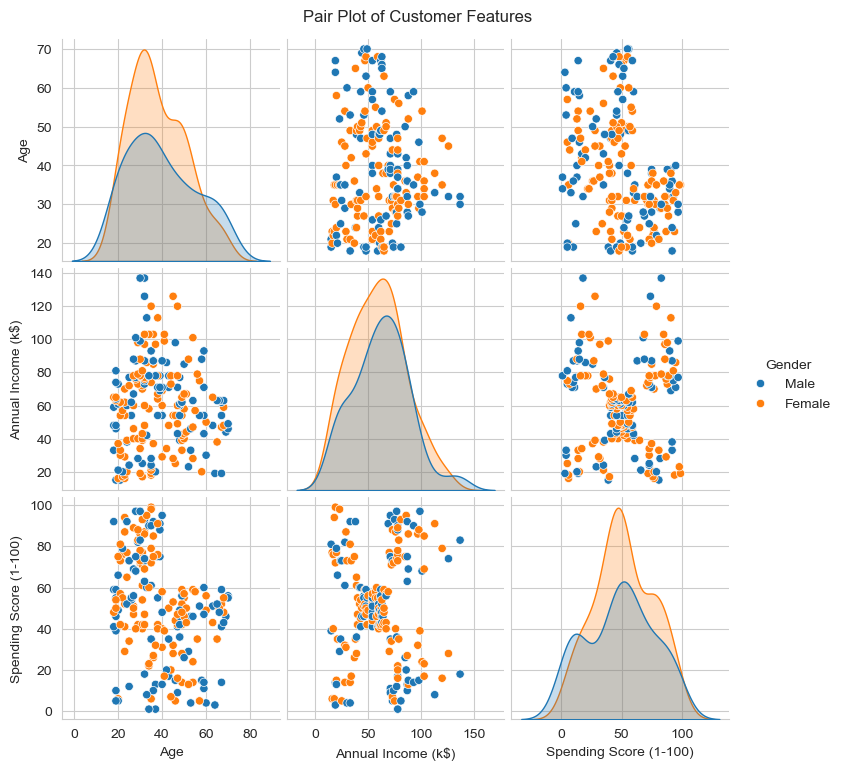

In [27]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

In [28]:
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

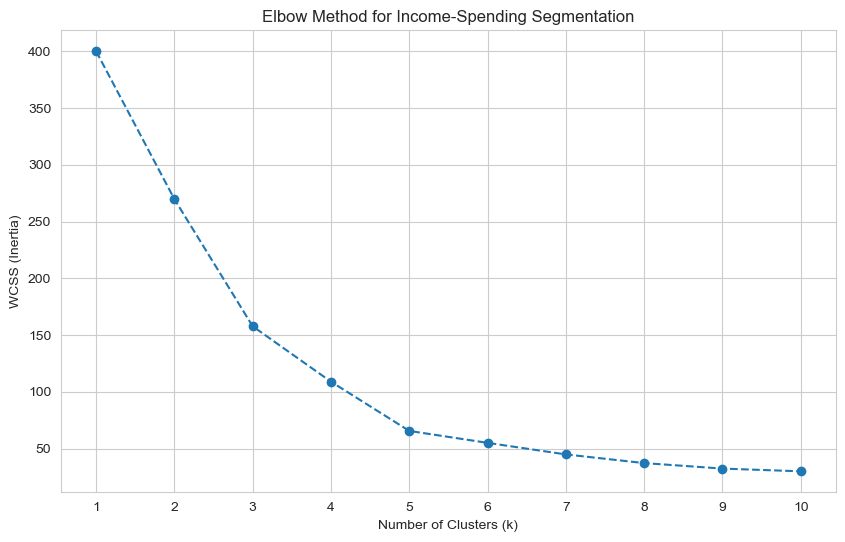

In [29]:
# 1. Select and scale the features
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

In [30]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

#### 3.1 Visualizing and Interpreting the Income-Based Segments

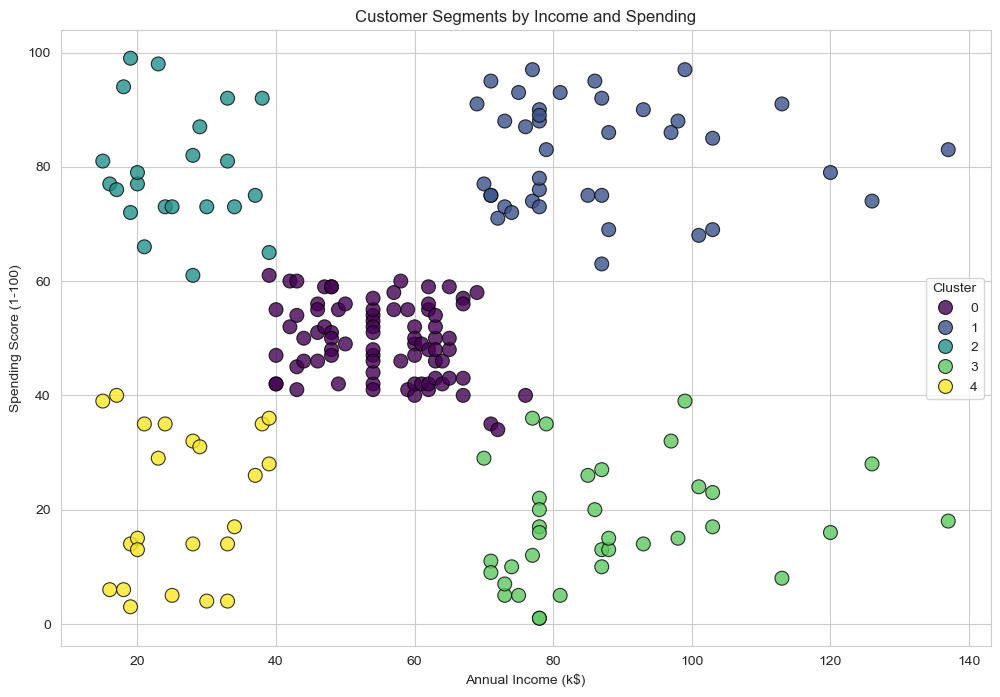

In [31]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [32]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


#### 3.2 Income-Based Personas and Strategy
Using the quantitative profiles, we can define our segments:
- **Cluster 0 (Careful High-Earners):** High income (~88k) but low spending (~17). Cautious, value-driven buyers.
- **Cluster 1 (Standard):** Average income (~55k) and spending (~50). This is the largest, core customer group.
- **Cluster 2 (Budget Shoppers):** Low income (~26k) and low spending (~21). Highly price-sensitive.
- **Cluster 3 (Target - High Value):** High income (~87k) and high spending (~82). The mall's prime target.
- **Cluster 4 (Enthusiasts):** Low income (~26k) but high spending (~79). Likely young, trend-focused shoppers.

### Step 4: Segmentation Model 2 - Age & Spending Score
Let's create a different segmentation model to see if we can find age-related customer groups.

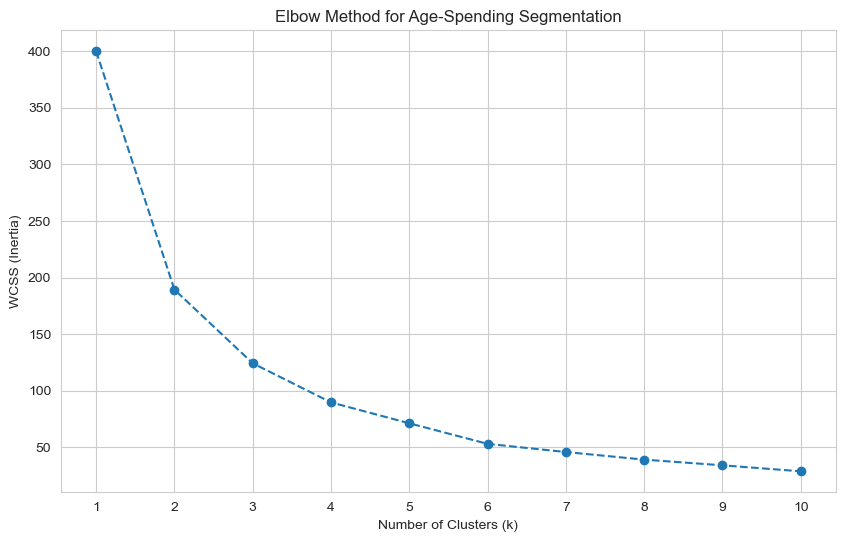

In [33]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

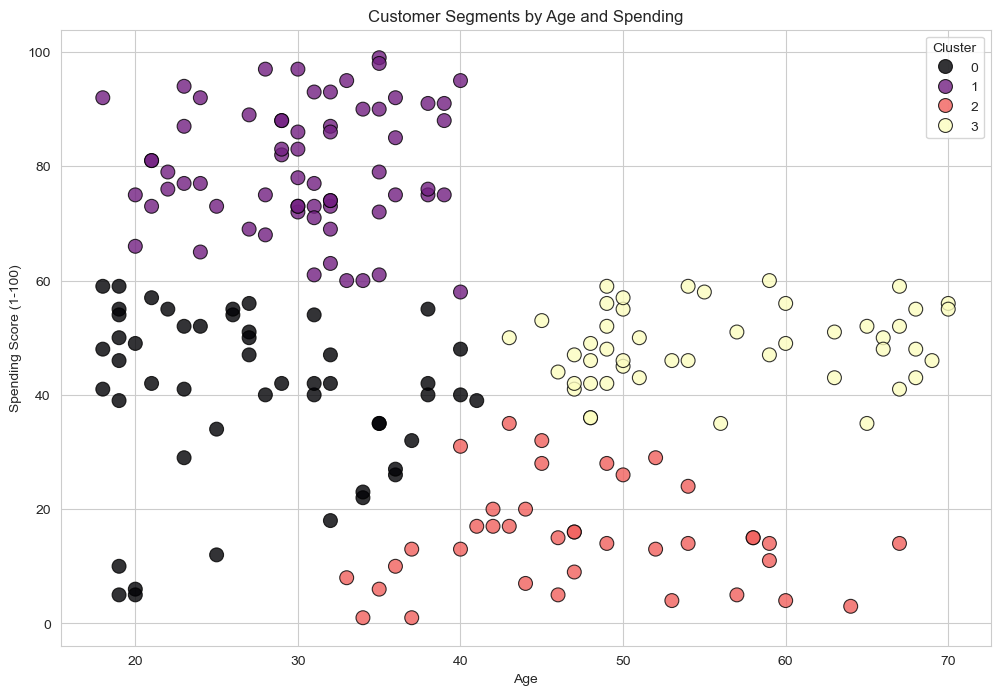

In [34]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

#### 4.1 Interpreting the Age-Based Segments
This model gives us a different perspective:
- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.
- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.
- **Older Average-Spenders:** Customers over 40 with moderate spending scores.
- **Older Low-Spenders:** A small group of older customers with very low spending scores.

### Step 5: An Alternative Method - Hierarchical Clustering
To add more depth, let's briefly look at another clustering technique.

#### **Theoretical Concept: Hierarchical Clustering & Dendrograms**
Unlike K-Means, Hierarchical Clustering doesn't require us to specify the number of clusters beforehand. It builds a tree-like hierarchy of clusters.

We can visualize this hierarchy with a **dendrogram**. The dendrogram shows how clusters are merged (or split). To find the optimal number of clusters, we look for the tallest vertical line that doesn't cross any horizontal lines and draw a horizontal line through it. The number of vertical lines our new line crosses is the optimal number of clusters.


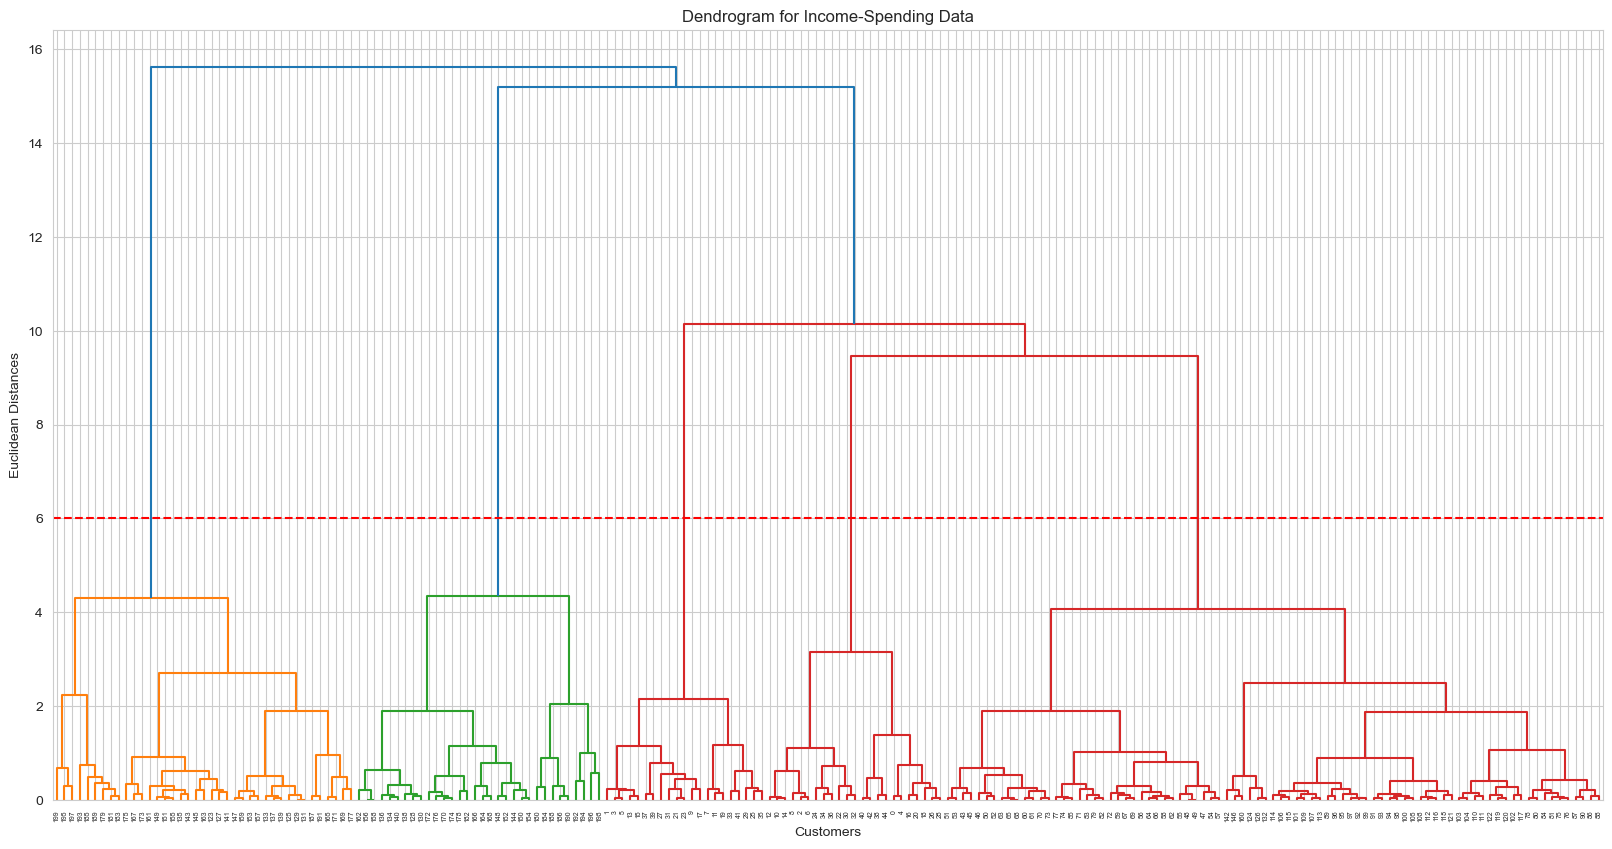

In [35]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

### Step 6: Conclusion

In this extended project, we successfully applied unsupervised machine learning to perform customer segmentation.

**Key Steps Undertaken:**
1.  **Performed an in-depth EDA:** Used 2D and 3D plots to explore customer data from multiple angles.
2.  **Built two distinct segmentation models:** Created an income-based model and an age-based model, showing that segmentation is not a one-size-fits-all process.
3.  **Used the Elbow Method** to programmatically determine the optimal number of clusters for each scenario.
4.  **Introduced Hierarchical Clustering** as an alternative method and used its dendrogram to validate our choice of `k`.
5.  **Created quantitative, data-driven personas** for each segment, providing the marketing team with precise, actionable insights for targeted campaigns.

This project highlights how different clustering approaches can uncover different facets of customer behavior, providing a richer, more nuanced understanding than a single model alone.

### Submission Criteria

Based on the project objectives and the insights gained from the initial analysis, here are the key criteria for your submission:

1.  **Explore Gender vs. Spending Score:** Analyze the relationship between 'Gender' and 'Spending Score (1-100)' to see if gender plays a significant role in spending habits. Visualizations and summary statistics would be helpful here.
2.  **Apply Feature Engineering for Clustering:** Create a new feature using existing data (Feature Engineering). Then, explore if clustering can be effectively performed using this newly engineered feature in combination with one or more existing features. Document the feature engineering process, the chosen features for clustering, the determination of the optimal number of clusters (e.g., using the Elbow Method), and the resulting cluster visualization and interpretation.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [37]:
mall_data = pd.read_csv('Mall_Customers.csv')

# Display basic information about the dataset
print("Dataset shape:", mall_data.shape)
print("\nDataset info:")
print(mall_data.info())
print("\nFirst few rows:")
print(mall_data.head())

Dataset shape: (200, 5)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

First few rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                    

Analysis 1: Gender vs Spending Score

Summary Statistics by Gender:
         count       mean       std  min   25%   50%   75%   max
Gender                                                         
Female  112.0  51.526786  24.11495  5.0  35.0  50.0  73.0  99.0
Male     88.0  48.511364  27.89677  1.0  24.5  50.0  70.0  97.0

T-test Results:
  T-statistic : -0.8190
  P-value     : 0.4137
  Significant : No


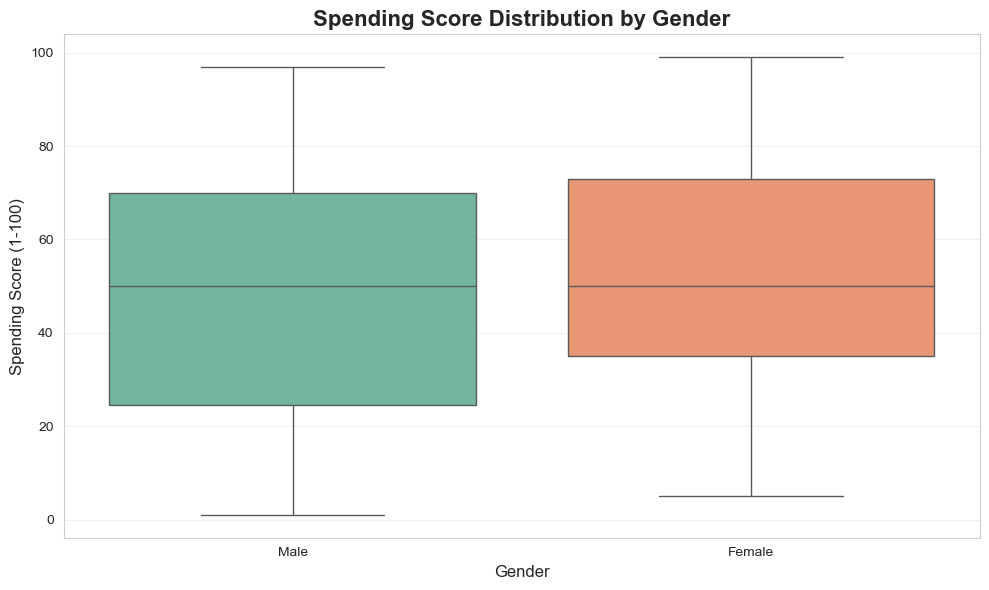

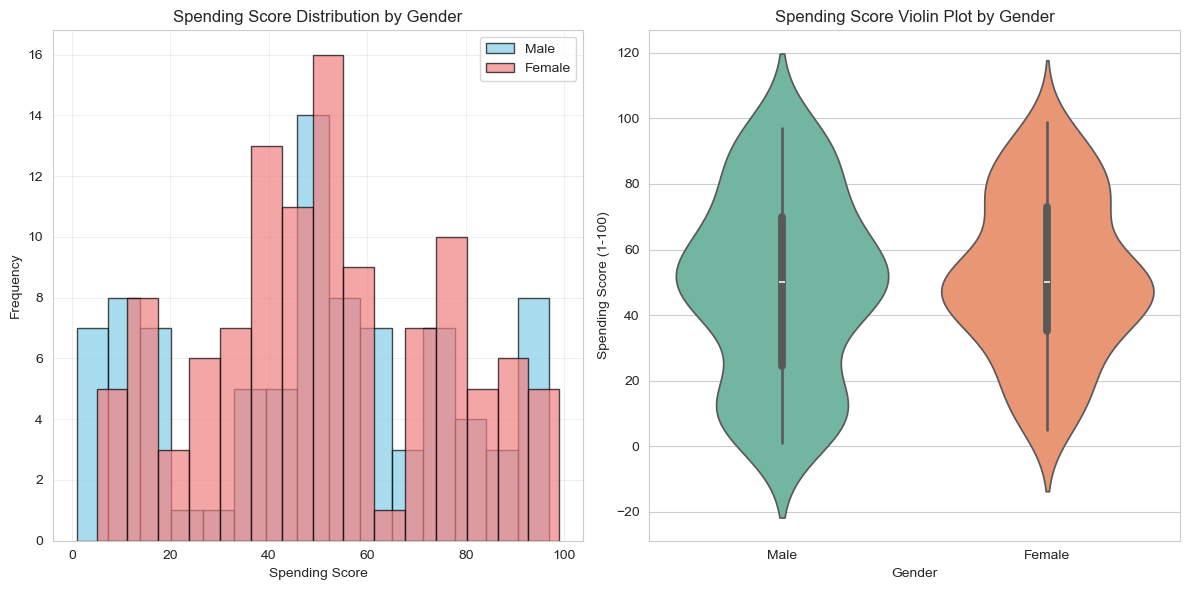

In [45]:

print("Analysis 1: Gender vs Spending Score")

# Summary statistics by gender
gender_stats = mall_data.groupby('Gender')['Spending Score (1-100)'].describe()
print("\nSummary Statistics by Gender:\n", gender_stats)

# Statistical test (t-test) to check if difference is significant
from scipy import stats

male_scores = mall_data[mall_data['Gender'] == 'Male']['Spending Score (1-100)']
female_scores = mall_data[mall_data['Gender'] == 'Female']['Spending Score (1-100)']

t_stat, p_value = stats.ttest_ind(male_scores, female_scores)
print(f"\nT-test Results:")
print(f"  T-statistic : {t_stat:.4f}")
print(f"  P-value     : {p_value:.4f}")
print(f"  Significant : {'Yes' if p_value < 0.05 else 'No'}")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, palette='Set2')
plt.title('Spending Score Distribution by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(male_scores, bins=15, alpha=0.7, label='Male', color='skyblue', edgecolor='black')
plt.hist(female_scores, bins=15, alpha=0.7, label='Female', color='lightcoral', edgecolor='black')
plt.xlabel('Spending Score')
plt.ylabel('Frequency')
plt.title('Spending Score Distribution by Gender')
plt.legend()
plt.grid(alpha=0.3)

# Violin Plot
plt.subplot(1, 2, 2)
sns.violinplot(x='Gender', y='Spending Score (1-100)', data=mall_data, palette='Set2')
plt.title('Spending Score Violin Plot by Gender')

plt.tight_layout()
plt.show()


In [39]:

# Analysis 2: Feature Engineering & Clustering
print("Analysis 2: Feature Engineering & Clustering")
print("-"*60)
# Step 1: Feature Engineering

mall_data['Income_Age_Ratio'] = mall_data['Annual Income (k$)'] / mall_data['Age']

print("\nNew Feature Created: 'Income_Age_Ratio'")
print("\nFeature Statistics:\n", mall_data['Income_Age_Ratio'].describe())


# Step 2: Feature Preparation for Clustering

features_for_clustering = mall_data[['Income_Age_Ratio', 'Spending Score (1-100)']]

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

print(f"\nFeatures standardized successfully.")
print(f"Shape of Scaled Features: {features_scaled.shape}")


Analysis 2: Feature Engineering & Clustering
------------------------------------------------------------

New Feature Created: 'Income_Age_Ratio'

Feature Statistics:
 count    200.000000
mean       1.751656
std        0.954720
min        0.283582
25%        0.913443
50%        1.579802
75%        2.486111
max        4.566667
Name: Income_Age_Ratio, dtype: float64

Features standardized successfully.
Shape of Scaled Features: (200, 2)



Optimal number of clusters (Elbow method): 4
Optimal number of clusters (Silhouette method): 7


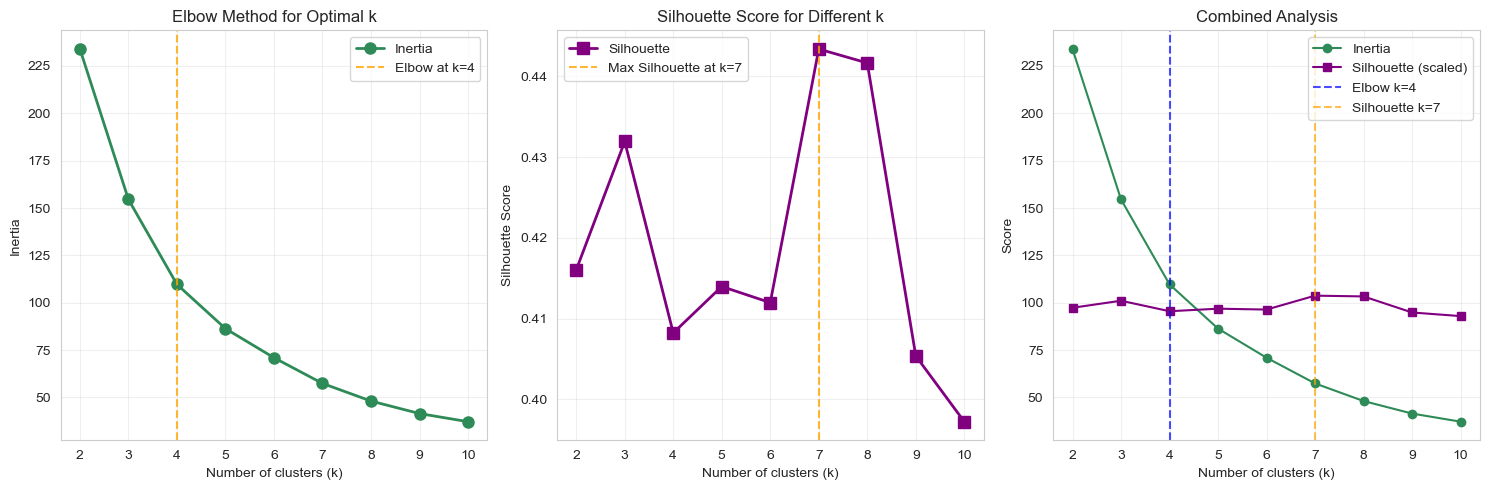

In [40]:

inertia_values = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot Elbow Method, Silhouette, and Combined Analysis
plt.figure(figsize=(15, 5))

# Elbow Method (Green)
plt.subplot(1, 3, 1)
plt.plot(cluster_range, inertia_values, color='seagreen', marker='o', linestyle='-', 
         markersize=8, linewidth=2, label='Inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(alpha=0.3)

# Silhouette Score (Purple)
plt.subplot(1, 3, 2)
plt.plot(cluster_range, silhouette_scores, color='purple', marker='s', linestyle='-', 
         markersize=8, linewidth=2, label='Silhouette')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(alpha=0.3)

# CORRECTED elbow point detection function
def find_elbow(x_vals, y_vals):
    """Find the elbow point using perpendicular distance from line method"""
    n_points = len(x_vals)
    all_coord = np.vstack((x_vals, y_vals)).T
    
    first_point = all_coord[0]
    last_point = all_coord[-1]
    line_vec = last_point - first_point
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    
    vec_from_first = all_coord - first_point
    scalar_product = np.dot(vec_from_first, line_vec_norm)
    vec_to_line = vec_from_first - np.outer(scalar_product, line_vec_norm)
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    
    return x_vals[np.argmax(dist_to_line)]

optimal_k = find_elbow(np.array(cluster_range), np.array(inertia_values))
print(f"\nOptimal number of clusters (Elbow method): {optimal_k}")

# Also find optimal k based on highest silhouette score
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (Silhouette method): {optimal_k_silhouette}")

# Highlight elbow points
plt.subplot(1, 3, 1)
plt.axvline(x=optimal_k, color='orange', linestyle='--', alpha=0.8, label=f'Elbow at k={optimal_k}')
plt.legend()

plt.subplot(1, 3, 2)
plt.axvline(x=optimal_k_silhouette, color='orange', linestyle='--', alpha=0.8, 
            label=f'Max Silhouette at k={optimal_k_silhouette}')
plt.legend()

# Combined Plot (Inertia + Silhouette)
plt.subplot(1, 3, 3)
plt.plot(cluster_range, inertia_values, color='seagreen', marker='o', linestyle='-', 
         markersize=6, label='Inertia')
plt.plot(cluster_range, np.array(silhouette_scores) * max(inertia_values), 
         color='purple', marker='s', linestyle='-', markersize=6, 
         label='Silhouette (scaled)')
plt.axvline(x=optimal_k, color='blue', linestyle='--', alpha=0.7, label=f'Elbow k={optimal_k}')
plt.axvline(x=optimal_k_silhouette, color='orange', linestyle='--', alpha=0.7, 
            label=f'Silhouette k={optimal_k_silhouette}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.title('Combined Analysis')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



K-Means clustering completed with k=4
Silhouette Score: 0.4082

Cluster Analysis:
        Income_Age_Ratio             Spending Score (1-100)           Age  \
                    mean   std count                   mean    std   mean   
Cluster                                                                     
0                   1.07  0.32    79                  55.85  14.29  44.03   
1                   2.91  0.62    30                  24.73  15.41  30.40   
2                   1.02  0.53    36                  19.03  11.26  48.64   
3                   2.58  0.59    55                  76.38  14.13  29.62   

        Annual Income (k$)  
                      mean  
Cluster                     
0                    45.65  
1                    84.60  
2                    49.42  
3                    76.16  


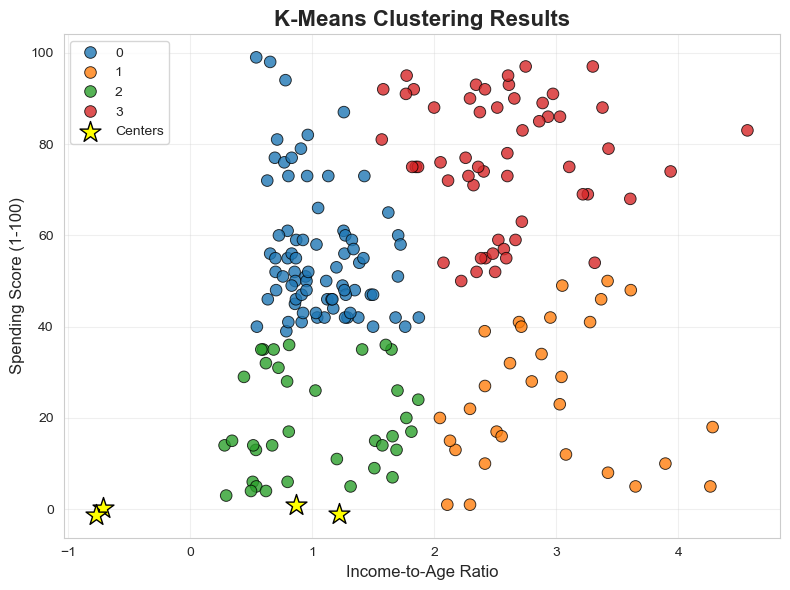

In [41]:


# Apply K-means with optimal number of clusters (k=4 chosen from elbow/silhouette)
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
mall_data['Cluster'] = kmeans_final.fit_predict(features_scaled)

print("\nK-Means clustering completed with k=4")
print(f"Silhouette Score: {silhouette_score(features_scaled, mall_data['Cluster']):.4f}")

cluster_analysis = mall_data.groupby('Cluster').agg({
    'Income_Age_Ratio': ['mean', 'std', 'count'],
    'Spending Score (1-100)': ['mean', 'std'],
    'Age': 'mean',
    'Annual Income (k$)': 'mean'
}).round(2)

print("\nCluster Analysis:")
print(cluster_analysis)

plt.figure(figsize=(8, 6))

# Pick a custom color palette for clarity
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red

sns.scatterplot(
    x='Income_Age_Ratio',
    y='Spending Score (1-100)',
    hue='Cluster',
    palette=palette,
    data=mall_data,
    s=70,
    alpha=0.8,
    edgecolor='black'
)

# Plot cluster centers
centers = kmeans_final.cluster_centers_
plt.scatter(
    centers[:, 0], centers[:, 1],
    c='yellow', s=250, marker='*', edgecolor='black', label='Centers'
)

plt.title('K-Means Clustering Results', fontsize=16, fontweight='bold')
plt.xlabel('Income-to-Age Ratio', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


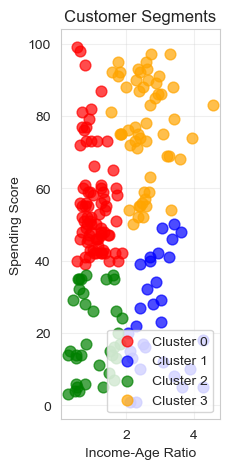

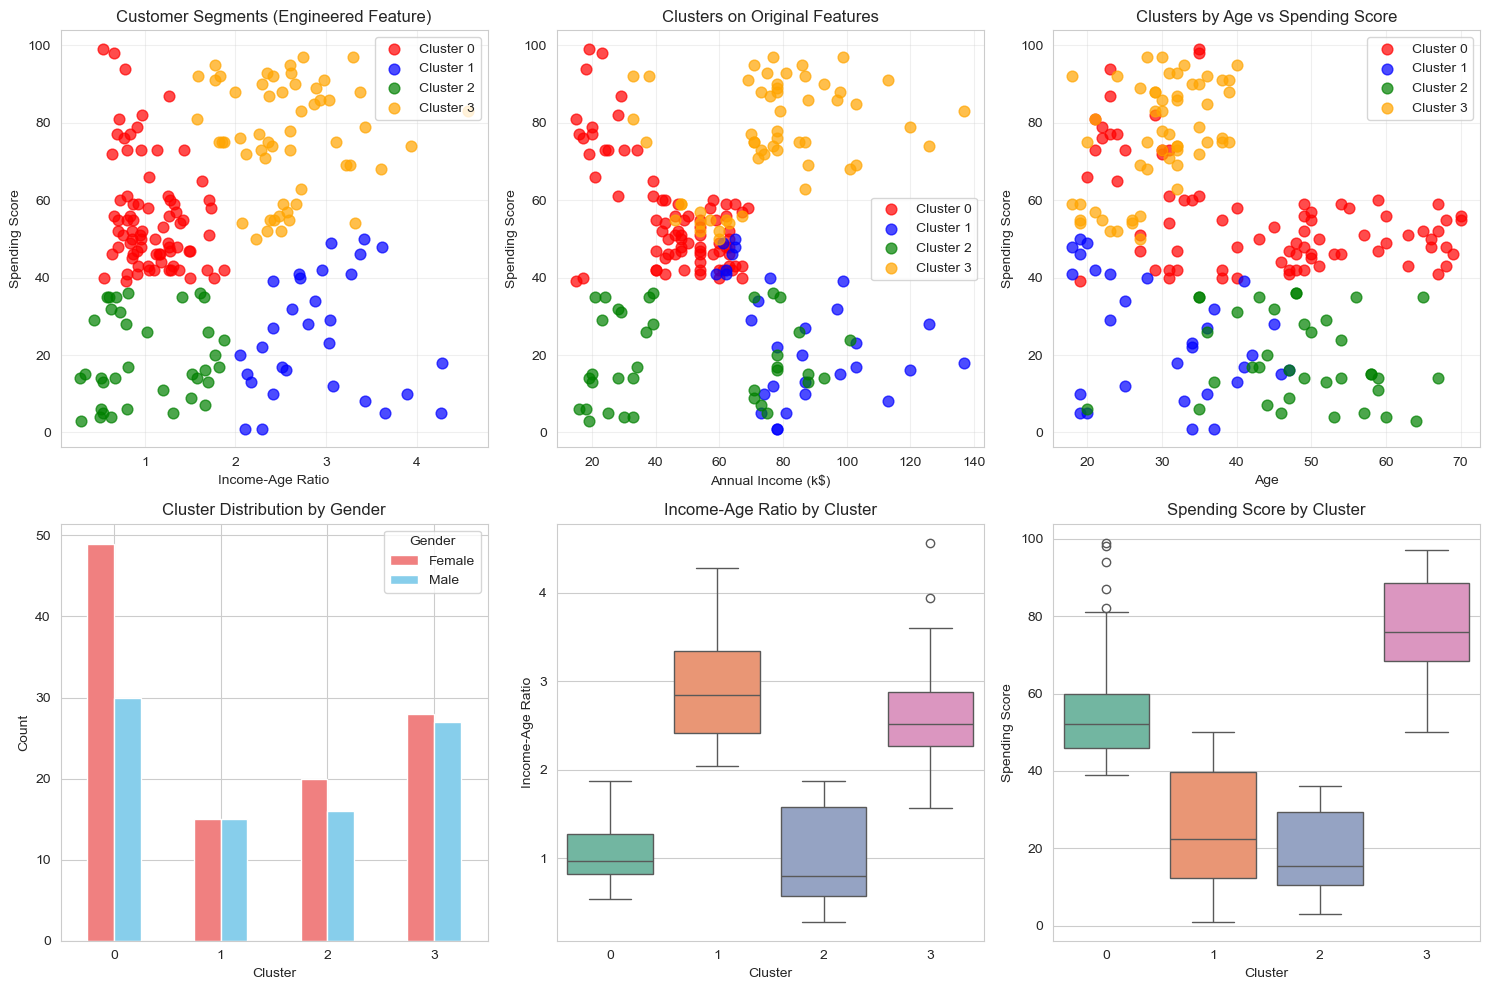

In [42]:
# Main cluster visualization
plt.subplot(1, 3, 3)
colors = ['red', 'blue', 'green', 'orange']
for i in range(4):
    cluster_data = mall_data[mall_data['Cluster'] == i]
    plt.scatter(cluster_data['Income_Age_Ratio'], 
                cluster_data['Spending Score (1-100)'], 
                c=colors[i], label=f'Cluster {i}', s=60, alpha=0.7)

plt.xlabel('Income-Age Ratio')
plt.ylabel('Spending Score')
plt.title('Customer Segments')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Detailed cluster visualization
plt.figure(figsize=(15, 10))

# Plot 1: Cluster scatter plot
plt.subplot(2, 3, 1)
for i in range(4):
    cluster_data = mall_data[mall_data['Cluster'] == i]
    plt.scatter(cluster_data['Income_Age_Ratio'], 
                cluster_data['Spending Score (1-100)'], 
                c=colors[i], label=f'Cluster {i}', s=60, alpha=0.7)
plt.xlabel('Income-Age Ratio')
plt.ylabel('Spending Score')
plt.title('Customer Segments (Engineered Feature)')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Original features scatter
plt.subplot(2, 3, 2)
for i in range(4):
    cluster_data = mall_data[mall_data['Cluster'] == i]
    plt.scatter(cluster_data['Annual Income (k$)'], 
                cluster_data['Spending Score (1-100)'], 
                c=colors[i], label=f'Cluster {i}', s=60, alpha=0.7)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.title('Clusters on Original Features')
plt.legend()
plt.grid(alpha=0.3)

# Plot 3: Age vs Spending Score
plt.subplot(2, 3, 3)
for i in range(4):
    cluster_data = mall_data[mall_data['Cluster'] == i]
    plt.scatter(cluster_data['Age'], 
                cluster_data['Spending Score (1-100)'], 
                c=colors[i], label=f'Cluster {i}', s=60, alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.title('Clusters by Age vs Spending Score')
plt.legend()
plt.grid(alpha=0.3)

# Plot 4: Cluster distribution by gender
plt.subplot(2, 3, 4)
cluster_gender = pd.crosstab(mall_data['Cluster'], mall_data['Gender'])
cluster_gender.plot(kind='bar', ax=plt.gca(), color=['lightcoral', 'skyblue'])
plt.title('Cluster Distribution by Gender')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Gender')

# Plot 5: Box plot of Income-Age Ratio by Cluster
plt.subplot(2, 3, 5)
sns.boxplot(x='Cluster', y='Income_Age_Ratio', data=mall_data, palette='Set2')
plt.title('Income-Age Ratio by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Income-Age Ratio')
plt.subplot(2, 3, 6)
sns.boxplot(x='Cluster', y='Spending Score (1-100)', data=mall_data, palette='Set2')
plt.title('Spending Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spending Score')

plt.tight_layout()
plt.show()

In [43]:
print("CLUSTER INTERPRETATION")
cluster_names = {
    0: "Moderate Earners & Spenders",
    1: "High Spenders (Young)",
    2: "Conservative Spenders",
    3: "Affluent High Spenders"
}

for cluster in range(4):
    cluster_data = mall_data[mall_data['Cluster'] == cluster]
    print(f"\n--- CLUSTER {cluster}: {cluster_names.get(cluster, 'Unknown')} ---")
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(mall_data)*100:.1f}%)")
    print(f"Average Age: {cluster_data['Age'].mean():.1f} years")
    print(f"Average Income: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"Average Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}")
    print(f"Average Income-Age Ratio: {cluster_data['Income_Age_Ratio'].mean():.3f}")
    print(f"Gender Distribution: {dict(cluster_data['Gender'].value_counts())}")

# Save results
results_df = mall_data[['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 
                       'Spending Score (1-100)', 'Income_Age_Ratio', 'Cluster']]
results_df.to_csv('customer_segments_analysis.csv', index=False)
print(f"\nResults saved to 'customer_segments_analysis.csv'")


print("Analysis done")


CLUSTER INTERPRETATION

--- CLUSTER 0: Moderate Earners & Spenders ---
Size: 79 customers (39.5%)
Average Age: 44.0 years
Average Income: $45.6k
Average Spending Score: 55.8
Average Income-Age Ratio: 1.070
Gender Distribution: {'Female': 49, 'Male': 30}

--- CLUSTER 1: High Spenders (Young) ---
Size: 30 customers (15.0%)
Average Age: 30.4 years
Average Income: $84.6k
Average Spending Score: 24.7
Average Income-Age Ratio: 2.914
Gender Distribution: {'Male': 15, 'Female': 15}

--- CLUSTER 2: Conservative Spenders ---
Size: 36 customers (18.0%)
Average Age: 48.6 years
Average Income: $49.4k
Average Spending Score: 19.0
Average Income-Age Ratio: 1.019
Gender Distribution: {'Female': 20, 'Male': 16}

--- CLUSTER 3: Affluent High Spenders ---
Size: 55 customers (27.5%)
Average Age: 29.6 years
Average Income: $76.2k
Average Spending Score: 76.4
Average Income-Age Ratio: 2.576
Gender Distribution: {'Female': 28, 'Male': 27}

Results saved to 'customer_segments_analysis.csv'
Analysis done
